# Scene Encoding Cross-Talk

This notebook uses HDVEC positional Fractional Power Encoding (FPE) and the `FieldEncoder` scene utility to explore round-trip accuracy and clean-up margins as the density of non-background cells increases.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from hdvec.core import bind, inv
from hdvec.core.codebook import Codebook
from hdvec.encoding.positional import Positional2DTorus
from hdvec.encoding.scene import FieldEncoder

In [3]:
D = 8192
rng = np.random.default_rng(7)

positional = Positional2DTorus(D=D, beta=0.5, rng=np.random.default_rng(1))
K = 10
codebook = np.stack([
    np.exp(1j * rng.uniform(-np.pi, np.pi, size=D)).astype(np.complex64)
    for _ in range(K)
], axis=0)

encoder = FieldEncoder(positional=positional, value_codebook=codebook)
cb = Codebook(codebook)

def decode_grid(scene: np.ndarray, H: int, W: int) -> np.ndarray:
    grid = np.zeros((H, W), dtype=np.int32)
    for i in range(H):
        for j in range(W):
            idx_score = encoder.read_cell(scene, i, j, (H, W))
            grid[i, j] = int(idx_score[0])
    return grid


In [4]:
H = W = 10
ratios = np.linspace(0.0, 1.0, 21)
accuracies = []
margin_means = []

pos_grid = positional.sample_grid(H, W)

for ratio in ratios:
    grid = np.zeros((H, W), dtype=np.int32)
    num_active = int(ratio * H * W)
    if num_active > 0:
        idx = rng.choice(H * W, size=num_active, replace=False)
        grid.flat[idx] = rng.integers(1, K, size=num_active)
    scene = encoder.encode_grid(grid)
    recon = decode_grid(scene, H, W)
    accuracies.append((recon == grid).mean())
    total_margin = 0.0
    count = 0
    for i in range(H):
        for j in range(W):
            pos = pos_grid[i, j]
            slot = bind(scene, inv(pos))
            idxs, scores = cb.topk(slot, k=min(2, K))
            if scores.size == 0:
                continue
            if scores.size == 1:
                margin = scores[0]
            else:
                margin = scores[0] - scores[1]
            total_margin += margin
            count += 1
    margin_means.append(total_margin / max(count, 1))


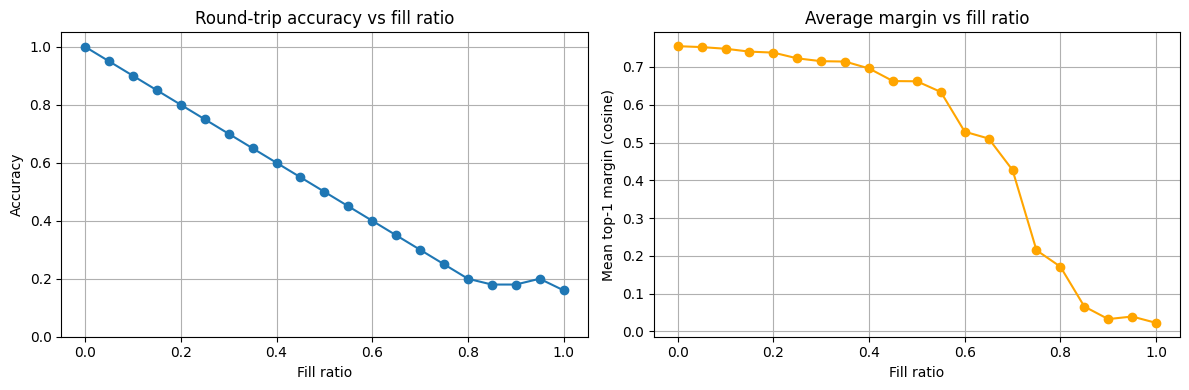

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(ratios, accuracies, marker='o')
ax[0].set_title('Round-trip accuracy vs fill ratio')
ax[0].set_xlabel('Fill ratio')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0, 1.05)
ax[0].grid(True)

ax[1].plot(ratios, margin_means, marker='o', color='orange')
ax[1].set_title('Average margin vs fill ratio')
ax[1].set_xlabel('Fill ratio')
ax[1].set_ylabel('Mean top-1 margin (cosine)')
ax[1].grid(True)

plt.tight_layout()
plt.show()
